In [217]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
df = pd.read_csv('20newsgroups.csv', names=['Text','labels'], skiprows=1)

In [218]:
def simplify_text(email_text):
    def extract_body(email_text):
        parts = email_text.split('\n\n', 1)
        if len(parts) > 1:
            body = parts[1].strip()
            body = re.split(r'\n--', body, maxsplit=1)[0].strip()
            body = body.replace('\n', ' ')
            return body
        return email_text

    def remove_before_writes(text):
        if "writes:" in text:
            return text.rsplit("writes:",1)[1].strip()
        if "says:" in text:
            return text.rsplit("says:",1)[1].strip()
        if "wrote:" in text:
            return text.rsplit("wrote:",1)[1].strip()
        return text

    def remove_before_edu(text):
        if ".edu" in text:
            return text.split(".edu", 1)[1].strip()
        return text

    def clean_repeated_punctuation_and_spaces(text):
        cleaned_text = re.sub(r'([.,!?;:-])\1+', r'\1', text)
        # Replace multiple spaces with a single space
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        # Strip leading and trailing spaces
        cleaned_text = cleaned_text.strip()
        return cleaned_text
    
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation.replace('.', '').replace(',', '').replace('?', '').replace('!', '')))

    def remove_websites_with_specific_domains(text):
        website_pattern = r'\S+(\.com|\.edu|\.org|\.net|\.gov|\.io|\.co|\.biz|\.info|\.me|\.tv|\.us|\.uk|\.ca|\.int|\.org\.uk|\.de|\.jp|\.fr|\.cn|\.au)\b'
        # Menghapus URL dari teks
        return re.sub(website_pattern, '', text, flags=re.IGNORECASE).strip()
    
    def remove_punctuation_start(text):
        return re.sub(r'^[^\w\s]+', '', text)

    email_text = extract_body(email_text)
    email_text = remove_before_writes(email_text)
    email_text = remove_before_edu(email_text)
    email_text = remove_punctuation(email_text)
    email_text = clean_repeated_punctuation_and_spaces(email_text)
    email_text = remove_websites_with_specific_domains(email_text)
    email_text = remove_punctuation_start(email_text)
    email_text = email_text.lower()
    return email_text

# Terapkan fungsi simplify_text ke kolom 'Text'
df['Text'] = df['Text'].apply(simplify_text)
df = df[df['Text'] != '']
df.drop_duplicates(subset=['Text'], inplace=True)
# df = Dataset.from_pandas(df)

# df = df.remove_columns(["__index_level_0__"])

In [219]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load pretrained model and tokenizer
pretrained = r'cardiffnlp/twitter-roberta-base-sentiment-latest'
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [220]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples,
        padding="max_length",
        max_length=256,
        return_tensors="pt",
    )
    return tokenized

# Tokenize the dataset
tokenized_dataset = df['Text'].apply(tokenize_function)

In [221]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy.special import softmax
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define a custom dataset
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to preprocess and predict in batches
def batch_predict(texts, batch_size=32):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(dataloader, desc="Predicting"):
            # Tokenize batch and move it to the GPU
            encoded_input = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
            encoded_input = {key: val.to(device) for key, val in encoded_input.items()}  # Ensure input is moved to the correct device
            outputs = model(**encoded_input)  # Forward pass
            scores = outputs.logits.detach().cpu().numpy()  # Get logits from model and move back to CPU
            probabilities = softmax(scores, axis=1)  # Apply softmax over axis 1
            all_predictions.extend(probabilities)
    
    return np.array(all_predictions)

# Apply the batch prediction to the dataframe
texts = df['Text'].tolist()
batch_size = 300  # Adjust this batch size as per GPU memory
predictions = batch_predict(texts, batch_size=batch_size)

# Add predictions and labels back to the dataframe
df['predictions'] = list(predictions)
df['predicted_label'] = np.argmax(predictions, axis=1)

Predicting: 100%|██████████| 59/59 [02:21<00:00,  2.40s/it]


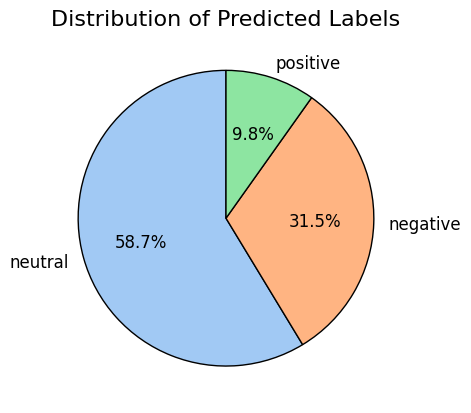

In [222]:
# Define the label mapping
label_mapping = model.config.id2label

# Decode the predicted labels
df['decoded_label'] = df['predicted_label'].map(label_mapping)

# Plot the distribution of decoded labels
colors = sns.color_palette('pastel')[0:3]
df['decoded_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title('Distribution of Predicted Labels', fontsize=16)
plt.ylabel('')
plt.show()

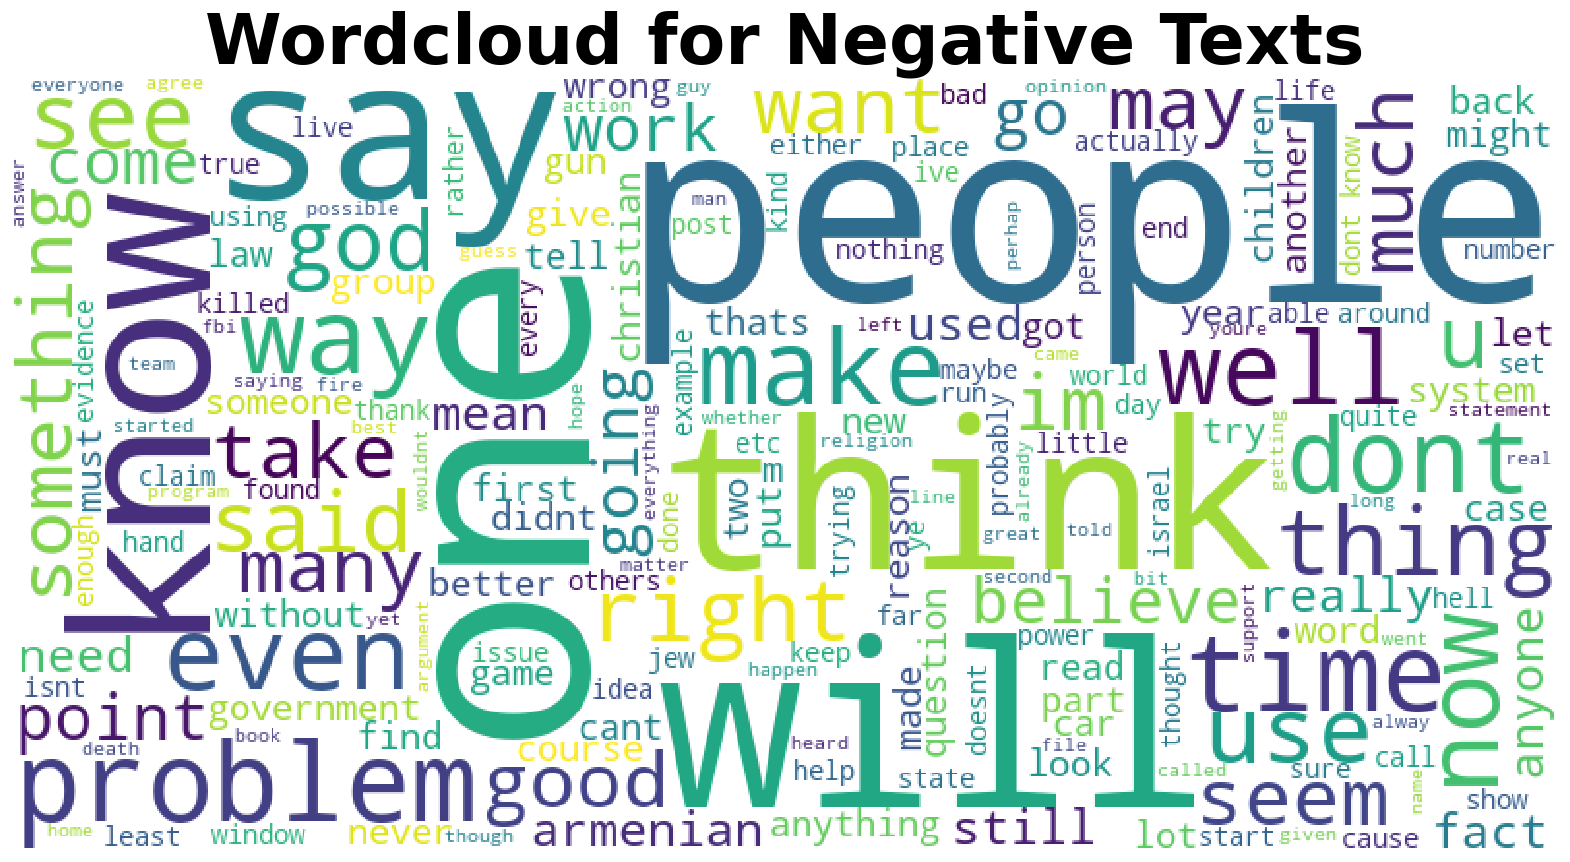

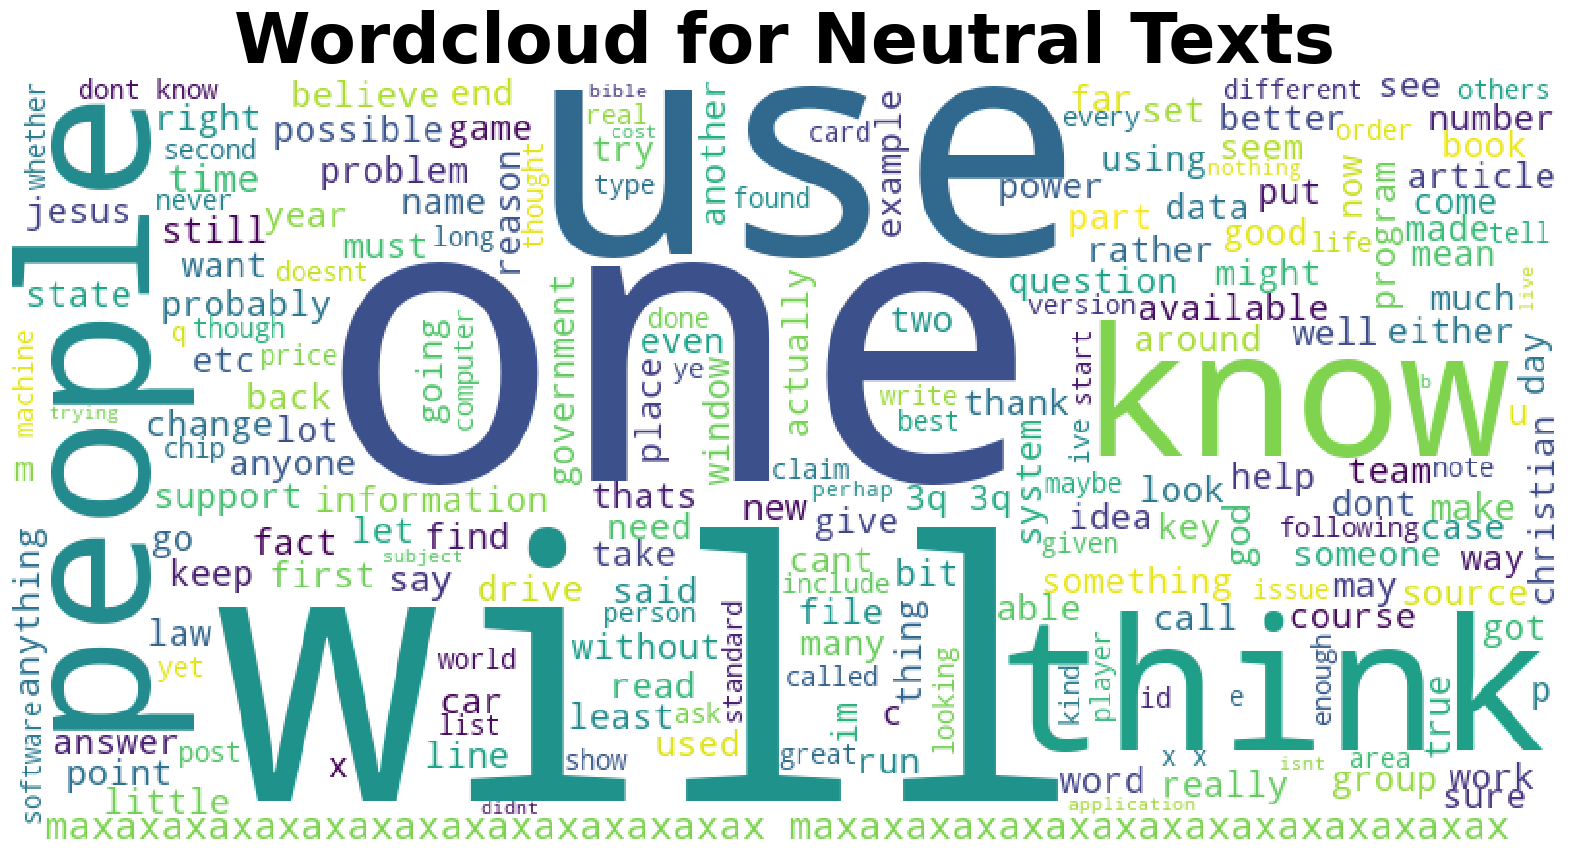

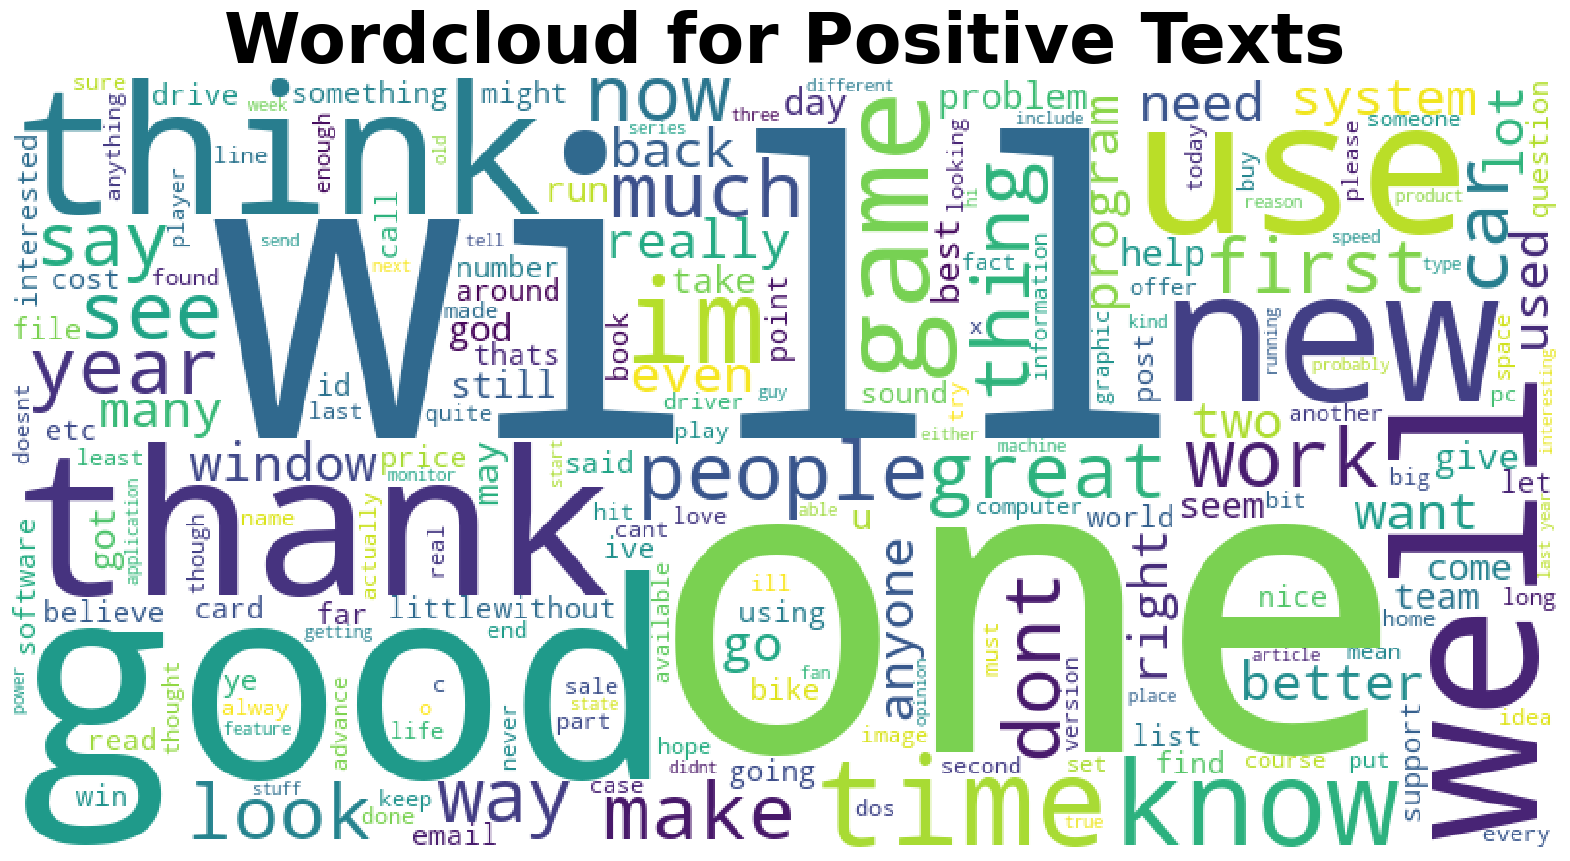

In [235]:
plt.figure(figsize=(20,20))

negative_texts_combined = ' '.join(df[df['decoded_label'] == 'negative']['Text'])
neutral_texts_combined = ' '.join(df[df['decoded_label'] == 'neutral']['Text'])
positive_texts_combined = ' '.join(df[df['decoded_label'] == 'positive']['Text'])

# Negative wordcloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts_combined)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_texts_combined)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts_combined)

plt.imshow(wordcloud_negative, interpolation='nearest')
plt.axis('off')
plt.title('Wordcloud for Negative Texts', fontsize=50, fontweight='bold')

plt.show()

plt.figure(figsize=(20,20))

# Neutral wordcloud
plt.imshow(wordcloud_neutral, interpolation='nearest')
plt.axis('off')
plt.title('Wordcloud for Neutral Texts', fontsize=50, fontweight='bold')

plt.show()

plt.figure(figsize=(20,20))

# Positive wordcloud
plt.imshow(wordcloud_positive, interpolation='nearest')
plt.axis('off')
plt.title('Wordcloud for Positive Texts', fontsize=50, fontweight='bold')

plt.show()
